## This is an example of how to use K-Means Clustering Method for Cluster Analysis of quantitative data, using Python, Pandas, NumPy, SciPy, Scikit-learn, Pingouin, Matplotlib, Seaborn and Plotly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px
import os
import plotly.io as pio
if os.getenv("GITHUB_ACTIONS") == "true":
    pio.renderers.default = "png"
else:
    pio.renderers.default='colab'

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

## Use Case Scenario and Data - Stores' Branches Evaluation

In this sample use case, there are 14 store branches that are being evaluated based on client feedbacks regarding the attending customer service, the assortment of items and the organization perceived by the client. For each of these features (quantitative data), we have the average score (grade) clients gave to each branch as our dataset. We want to proceed Cluster Analysis on this data in order to segment (clusterize) the branches according to data patterns not yet known to the administration, so that strategic decisions can be made in order to improve quality and value to the client.

In [2]:
# reading and displaying our dataset
retailer_data = pd.read_excel("regional_retailer.xlsx")
retailer_data_without_store_region = retailer_data.drop(columns=["STORE","REGION"])
retailer_data

,STORE,REGION,SERVICE,ASSORTMENT,ORGANIZATION
0,1,Region 3,6,6,4
1,2,Region 3,14,2,4
2,3,Region 3,8,4,6
3,4,Region 3,4,4,4
4,5,Region 3,6,6,6
5,6,Region 2,38,38,100
6,7,Region 1,40,78,38
7,8,Region 3,6,4,4
8,9,Region 3,4,4,6
9,10,Region 3,6,6,2


Ps.: initial data descriptives and 3D visualization have been demonstrated already at the .ipynb below (equivalent to this one), and, as then, no normalization of data is necessary here as well - the dataset is the same. Here, we start by directly implementing the clustering process itself, using K-Means instead of the Hierarchical Aggregative method. For data descriptives and graphical visualization, and for the demonstration of the Hierarchical Aggregative method, please see the other .ipynb, available at:<br>
[sample-ml-clustering-hierarchical-agglomerative-store.ipynb](./sample-ml-clustering-hierarchical-agglomerative-store.ipynb)

## K-Means Clustering Method

In [3]:
# proceeding the clustering, using K-Means method and considering that we have defined that 3 clusters should be the output - and 
# we want the algorithm to allocate the right elements inside them:
kmeans = KMeans(n_clusters=3, init='random', random_state=100).fit(retailer_data_without_store_region)

# extracting the generated labels from the final kmeans clustering result and setting that as a new category variable at the 
# original dataframe for describing which cluster each observation belongs to, after the clustering has been concluded. Here we 
# have cluster 0 (with stores 1,2,3,4,5,8.9.10,16,18), cluster 1 (with stores 7, 14, 15, 17) and cluster 2 (with stores 6,11,12,
# 13).
kmeans_clusters_labels = kmeans.labels_
retailer_data['CLUSTER_INDICATOR_KMEANS']=kmeans_clusters_labels
retailer_data['CLUSTER_INDICATOR_KMEANS']=retailer_data['CLUSTER_INDICATOR_KMEANS'].astype('category')
retailer_data.sort_values("CLUSTER_INDICATOR_KMEANS")

,STORE,REGION,SERVICE,ASSORTMENT,ORGANIZATION,CLUSTER_INDICATOR_KMEANS
0,1,Region 3,6,6,4,0
15,16,Region 3,2,4,4,0
9,10,Region 3,6,6,2,0
7,8,Region 3,6,4,4,0
8,9,Region 3,4,4,6,0
3,4,Region 3,4,4,4,0
2,3,Region 3,8,4,6,0
1,2,Region 3,14,2,4,0
4,5,Region 3,6,6,6,0
17,18,Region 3,6,2,4,0


In [4]:
retailer_data.groupby("CLUSTER_INDICATOR_KMEANS", observed=True).agg(
    STORE=("STORE", list),
    AVG_SERVICE=("SERVICE", "mean"),
    AVG_ASSORTMENT=("ASSORTMENT", "mean"),
    AVG_ORGANIZATION=("ORGANIZATION", "mean"),
).reset_index().style.hide(axis="index")

CLUSTER_INDICATOR_KMEANS,STORE,AVG_SERVICE,AVG_ASSORTMENT,AVG_ORGANIZATION
0,"[1, 2, 3, 4, 5, 8, 9, 10, 16, 18]",6.200000,4.200000,4.400000
1,"[7, 14, 15, 17]",56.000000,74.000000,45.000000
2,"[6, 11, 12, 13]",55.000000,41.000000,93.000000


In [5]:
# extracting the final centroids' coordinates for the final kmeans clusters
# all three variables' values are the 3D coordinates for each cluster below
kmeans_clusters_centroids = pd.DataFrame(kmeans.cluster_centers_)
kmeans_clusters_centroids.columns=retailer_data_without_store_region.columns
kmeans_clusters_centroids['CLUSTER_INDICATOR_KMEANS']='Cluster_'+kmeans_clusters_centroids.index.astype(str)
kmeans_clusters_centroids.style.hide(axis="index")

SERVICE,ASSORTMENT,ORGANIZATION,CLUSTER_INDICATOR_KMEANS
6.200000,4.200000,4.400000,Cluster_0
56.000000,74.000000,45.000000,Cluster_1
55.000000,41.000000,93.000000,Cluster_2


In [6]:
# we can plot and see the observations and centroids using a 3D graph, as below:

import plotly.graph_objects as go
fig = go.Figure()

# ---------- 1. Centroids scatter ----------
fig.add_trace(go.Scatter3d(
    x=kmeans_clusters_centroids["SERVICE"],
    y=kmeans_clusters_centroids["ASSORTMENT"],
    z=kmeans_clusters_centroids["ORGANIZATION"],
    mode='markers+text',
    text=kmeans_clusters_centroids["CLUSTER_INDICATOR_KMEANS"],
    textposition='bottom center',
    textfont=dict(size=10),
    name="Centroids",
    marker=dict(size=8, color="red", symbol="diamond")
))

# ---------- 2. Stores scatter ----------
fig.add_trace(go.Scatter3d(
    x=retailer_data["SERVICE"],
    y=retailer_data["ASSORTMENT"],
    z=retailer_data["ORGANIZATION"],
    mode='markers+text',
    text=retailer_data["STORE"],
    textposition='top center',
    textfont=dict(size=10),
    name="Stores",
    marker=dict(size=3, color="blue")
))

# ---------- Layout ----------
fig.update_layout(
    title=dict(
        text="Stores & KMeans Centroids",
        subtitle=dict(
            text="(3D Space - Service x Assortment x Organization)",
            font=dict(size=11)
        ),
        x=0.5,
        xanchor='center',
        font=dict(size=14),
        pad=dict(t=0, b=0)
    ),
    legend=dict(
        itemsizing='constant',
        font=dict(size=11),
    ),
    scene=dict(
        xaxis=dict(title=dict(text="SERVICE",font=dict(size=10)),tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="ASSORTMENT",font=dict(size=10)),tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="ORGANIZATION",font=dict(size=10)),tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(
        l=80,
        r=80,
        t=90,
        b=50
    )
)

# ---------- Save ----------
fig.write_html('stores_and_centroids_3d.html')
fig.show()

In [7]:
# In the case of KMeans method, there are a couple of ways of knowing in advance how many clusters we shall have at the end
# of the clustering process. One way would be to perform the hierarchical agglomerative process to discover the clusters' number
# and only then perform the KMeans method to check if a better result was reached. But that is quite repetitive and laborious. 

# ELBOW METHOD
# A better way of simply calculating the number of ideal clusters when using KMeans is to use the Elbow method, which charts a 
# WCSS x Clusters' Number line. This line shows how much the increase on the number of clusters reduces the WCSS (Within-Cluster 
# Sum of Squares), there is, the average proximity between the clusters towards their respecive centroids. Initially, the more 
# clusters we have, the least the WCSS tends to be, or, the closest the observations tend to be to their respective centroids. 
# But there is a limit, noticed at the "elbow" of this graph line, starting from which there's no more considerable reduction on 
# the WCSS when the number of clusters are further incresed. The number of clusters at that "elbow" point at the Elbow method 
# graph should be the number of clusters taken, by the KMeans algorithm, as the aimed clusters' number at the end of the 
# clustering process. In this case, as we know already, it would be 3.

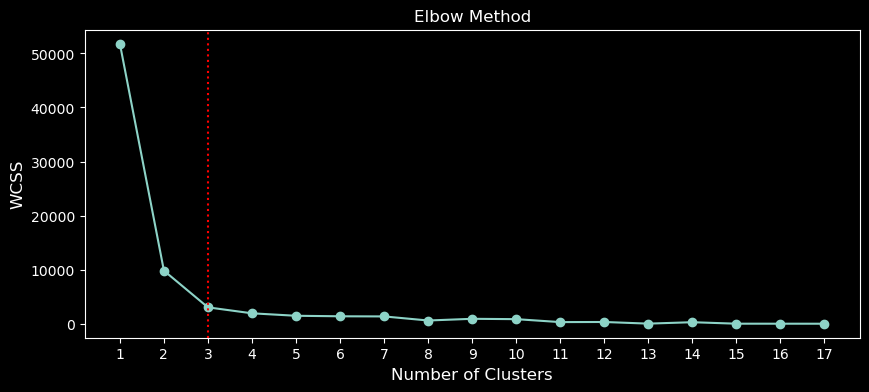

In [8]:
elbow = []
# A stopping point with max no. of clusters admitted is set below... as we have only 18 observations, the max no. of clusters would 
# be 17, 'cause if it were 18, there would be no clusterization at all - each observation would be a cluster on its own, as it 
# happens in a non-clusterized set of observations. So the range of possible clusters' number would be from 1 to (n-1), as below.
# The KMeans algorithm is run for each k number of clusters, and the respective WCSS values are collected (from the inertia_ 
# attribute), and then the graph is plotted. We can see that, starting from 3 clusters, the reduction on the WCSS starts being 
# visually neglectful. That's the elbow point, and, thus, we should choose 3 clusters at our KMeans clustering, for this dataset.
K = range(1,18)
for k in K:
    kmeanElbow = KMeans(n_clusters=k, init='random', random_state=100).fit(retailer_data_without_store_region)
    elbow.append(kmeanElbow.inertia_)
plt.figure(figsize=(10,4))
plt.plot(K, elbow, marker='o')
plt.xlabel('Number of Clusters', fontsize=12)
plt.xticks(range(1,18))
plt.ylabel('WCSS', fontsize=12)
plt.axvline(x = 3, linestyle = 'dotted', color = 'red') 
plt.title('Elbow Method', fontsize=12)
plt.show()

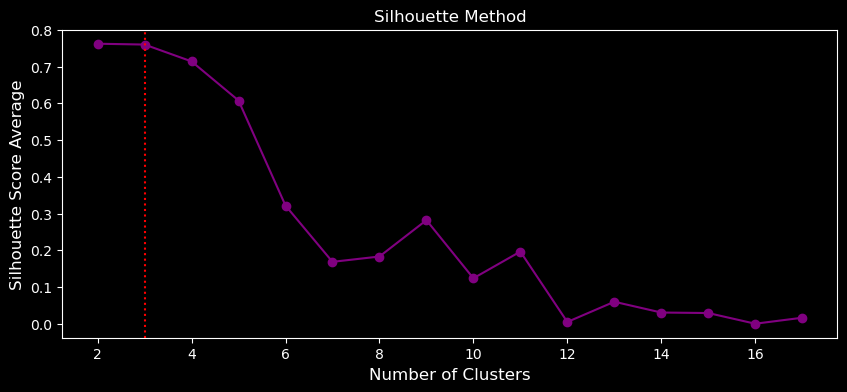

In [9]:
# Another way of discovering the number of ideal clusters for a K-Means clusterization is to use the silhouette method.

# SILHOUETTE METHOD
# the silhouette method calculates, for each observation, the relation between (b-a)/max(a,b), being "b" the avg distance between
# the observationa and the closest cluster where the observationa are not allocated at, and "a" the avg distance between the 
# observations and the cluster where the observations are allocated at. The higher the value of b and the lowest the value of a,
# the better the clusterization for each particular observation (farther from the closest cluster and closer to its own cluster).
# Simply put, we should choose the max number of clusters for which the silhouette score in average would be closer to 1. Which, 
# again, in this case, would be 3 clusters - as 2 and 3 have basically the same silhouette score. Therefore, we'll keep choosing 3.

silhouette = []
I = range(2,18)
for i in I: 
    kmeanSilhouette = KMeans(n_clusters=i, init='random', random_state=100).fit(retailer_data_without_store_region)
    silhouette.append(silhouette_score(retailer_data_without_store_region, kmeanSilhouette.labels_))

plt.figure(figsize=(10,4))
plt.plot(range(2, 18), silhouette, color = 'purple', marker='o')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score Average', fontsize=12)
plt.title('Silhouette Method', fontsize=12)
plt.axvline(x = 3, linestyle = 'dotted', color = 'red') 
plt.show()

In [10]:
# ANOVA METHOD
# This test is done, for each variable, individually, in order to evaluate how much difference we have between elements at 
# different cluster groups when compared to elements within the same cluster groups. In other words, if the mean of the 
# observations' values for that variable inside any of the clusters is statistically different from the mean of the 
# corresponding values, for the same variable, at other clusters. A third way to view, is how much contribution that variable
# confer to the dataset in order to justify the formation of at least one cluster, with some elements separated from others,
# because of the values (mean) of that variable. This analysis is done for each variable, individually. More than one variable 
# may contribute to the formation of the clusters. For such a variable, if the p-value (p-unc) is statistically significant, 
# that is, if it is less than the standard 0.05 (5%) significance value (> 95% confidance), it means that the contribution of 
# such a variable to the formation of at least one cluster is statistically significant... the higher the F value for that 
# variable, the higher the contribution of that variable to the formation of least one cluster.

# At the current example, according to the statistics below, all 3 variables contributed significantly (p<0.05)to make all 3 
# clusters meaningful, being the Organization variable the one that contibuted the most (higher F value).

# CLUSTER_INDICATOR_KMEANS MS: indicates the variability between groups
# Within MS: indicates the variability within the groups
# F: test statistic (CLUSTER_INDICATOR_KMEANS MS / Within MS)
# p-unc: p-value of the F statistic
# If p-value < 0.05: at least one cluster has a mean statistically different from the others because of that variable's values

In [11]:
# Anova for the Service variable
pg.anova(dv='SERVICE', between='CLUSTER_INDICATOR_KMEANS', data=retailer_data, detailed=True).T

,0,1
Source,CLUSTER_INDICATOR_KMEANS,Within
SS,10804.177778,1591.6
DF,2,15
MS,5402.088889,106.106667
F,50.911871,NaN
p-unc,0.0,NaN
np2,0.871601,NaN


In [12]:
# Anova for the Assortment variable
pg.anova(dv='ASSORTMENT', between='CLUSTER_INDICATOR_KMEANS', data=retailer_data, detailed=True).T

,0,1
Source,CLUSTER_INDICATOR_KMEANS,Within
SS,14804.177778,1007.6
DF,2,15
MS,7402.088889,67.173333
F,110.19386,NaN
p-unc,0.0,NaN
np2,0.936275,NaN


In [13]:
# Anova for the Organization variable
pg.anova(dv='ORGANIZATION', between='CLUSTER_INDICATOR_KMEANS', data=retailer_data, detailed=True).T

,0,1
Source,CLUSTER_INDICATOR_KMEANS,Within
SS,23155.377778,430.4
DF,2,15
MS,11577.688889,28.693333
F,403.497522,NaN
p-unc,0.0,NaN
np2,0.981752,NaN


In [14]:
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure()

# get unique clusters
clusters = retailer_data["CLUSTER_INDICATOR_KMEANS"].unique()

# loop through clusters and create a separate trace for each
for cluster in clusters:
    cluster_data = retailer_data[retailer_data["CLUSTER_INDICATOR_KMEANS"] == cluster]
    
    fig.add_trace(go.Scatter3d(
        x=cluster_data["SERVICE"],
        y=cluster_data["ASSORTMENT"],
        z=cluster_data["ORGANIZATION"],
        mode='markers+text',
        text=cluster_data["STORE"],
        textposition='top center',
        textfont=dict(size=10),
        name=f"Cluster {cluster}",
        marker=dict(
            size=4,
            color=cluster,
            colorscale='Rainbow',
            showscale=False
        )
    ))

fig.update_layout(
    title=dict(
        text="Store Customer Feedback (1-100) - K-Means Clustering - Final",
        subtitle=dict(
            text="(3D Space: Attendance Service × Assortment × Organization)",
            font=dict(size=11)
        ),
        x=0.5,
        xanchor='center',
        font=dict(size=14),
        pad=dict(t=0, b=0)
    ),
    legend=dict(
        itemsizing='constant',
        font=dict(size=11)
    ),
    showlegend=True,
    scene=dict(
        xaxis=dict(title=dict(text="SERVICE", font=dict(size=10)), tickfont=dict(size=9)),
        yaxis=dict(title=dict(text="ASSORTMENT", font=dict(size=10)), tickfont=dict(size=9)),
        zaxis=dict(title=dict(text="ORGANIZATION", font=dict(size=10)), tickfont=dict(size=9))
    ),
    width=600,
    height=500,
    margin=dict(l=80, r=80, t=90, b=50)
)

fig.write_html('retailer_final_kmeans.html')
fig.show()
